<a href="https://colab.research.google.com/github/sugiawan2402/Hybrid-Resnet50-and-Mobilenetv2/blob/main/Hybrid%20Resnet50%20and%20Mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/My Drive/data/dataset'

runs  test  test.cache	train  train.cache  valid


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision import transforms
import torchvision.datasets as datasets


In [ ]:
import os

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}


In [ ]:
data_dir = '/content/gdrive/MyDrive/data/dataset'
batch_size = 32
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Load pretrained models
resnet = models.resnet50(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)

# Extract features from both models
resnet_features = resnet.fc.in_features
mobilenet_features = mobilenet.classifier[1].in_features
resnet.fc = nn.Identity()
mobilenet.classifier[1] = nn.Identity()

# Combine the models
class CombinedModel(nn.Module):
    def __init__(self, resnet, mobilenet, num_classes):
        super(CombinedModel, self).__init__()
        self.resnet = resnet
        self.mobilenet = mobilenet
        self.fc = nn.Linear(resnet_features + mobilenet_features, num_classes)

    def forward(self, x):
        resnet_output = self.resnet(x)
        mobilenet_output = self.mobilenet(x)
        combined = torch.cat((resnet_output, mobilenet_output), dim=1)
        output = self.fc(combined)
        return output

model = CombinedModel(resnet, mobilenet, num_classes=len(image_datasets['train'].classes))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 318MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 100
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = corrects.double() / len(image_datasets[phase])

        print(f'Epoch {epoch}/{num_epochs} | {phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


Epoch 0/100 | train Loss: 1.1152 Acc: 0.4118
Epoch 0/100 | valid Loss: 1.0498 Acc: 0.4667
Epoch 1/100 | train Loss: 0.9326 Acc: 0.4902
Epoch 1/100 | valid Loss: 0.9608 Acc: 0.5333
Epoch 2/100 | train Loss: 0.9565 Acc: 0.5098
Epoch 2/100 | valid Loss: 0.8922 Acc: 0.5333
Epoch 3/100 | train Loss: 0.8226 Acc: 0.5686
Epoch 3/100 | valid Loss: 0.8230 Acc: 0.7333
Epoch 4/100 | train Loss: 0.6781 Acc: 0.7255
Epoch 4/100 | valid Loss: 0.8010 Acc: 0.5333
Epoch 5/100 | train Loss: 0.5717 Acc: 0.8627
Epoch 5/100 | valid Loss: 0.7505 Acc: 0.7333
Epoch 6/100 | train Loss: 0.5184 Acc: 0.9412
Epoch 6/100 | valid Loss: 0.6748 Acc: 0.8000
Epoch 7/100 | train Loss: 0.4322 Acc: 0.8627
Epoch 7/100 | valid Loss: 0.6178 Acc: 0.8000
Epoch 8/100 | train Loss: 0.3949 Acc: 0.8235
Epoch 8/100 | valid Loss: 0.5910 Acc: 0.8000
Epoch 9/100 | train Loss: 0.3148 Acc: 0.8431
Epoch 9/100 | valid Loss: 0.5512 Acc: 0.8667
Epoch 10/100 | train Loss: 0.2305 Acc: 0.9804
Epoch 10/100 | valid Loss: 0.5352 Acc: 0.8667
Epoch 11

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/data/Hybrid Resnet50 and Mobilenetv2/Hybrid-Resnet50-and-Mobilenetv2.pth')

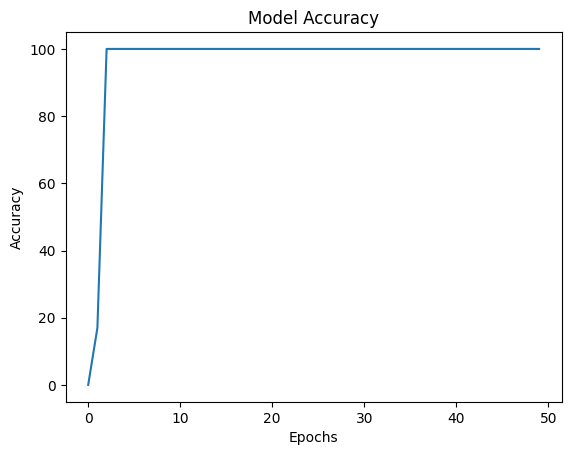

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Definisikan direktori untuk penyimpanan file PNG
save_dir = '/content/gdrive/MyDrive/data/Hybrid_Resnet50_Mobilenetv2/'

# Pastikan direktori sudah ada atau buat jika belum ada
os.makedirs(save_dir, exist_ok=True)

# ... (Kode pelatihan model dan pengumpulan akurasi seperti yang telah Anda siapkan sebelumnya) ...

# Plot grafik akurasi
plt.figure()
plt.plot(range(num_epochs), [accuracy * 100 for accuracy in accuracies])  # Untuk menampilkan akurasi dalam persentase
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

# Simpan grafik sebagai file PNG
plt.savefig(os.path.join(save_dir, 'model_accuracy.png'))
plt.show()


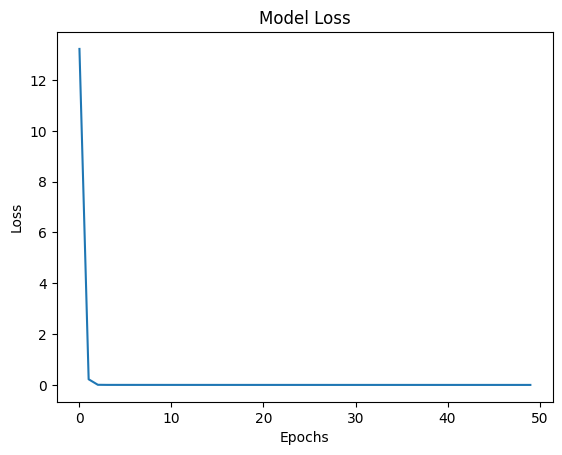

In [ ]:
# ... (Kode pelatihan model dan pengumpulan losses seperti yang telah Anda siapkan sebelumnya) ...

# Plot grafik loss
plt.figure()
plt.plot(range(num_epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

# Simpan grafik loss sebagai file PNG
plt.savefig(os.path.join(save_dir, 'model_loss.png'))
plt.show()


In [ ]:
# Simpan grafik loss sebagai file PNG
save_dir = '/content/gdrive/MyDrive/data/Hybrid_Resnet50_Mobilenetv2/'
plt.savefig(os.path.join(save_dir, 'model_loss.png'))


<Figure size 640x480 with 0 Axes>

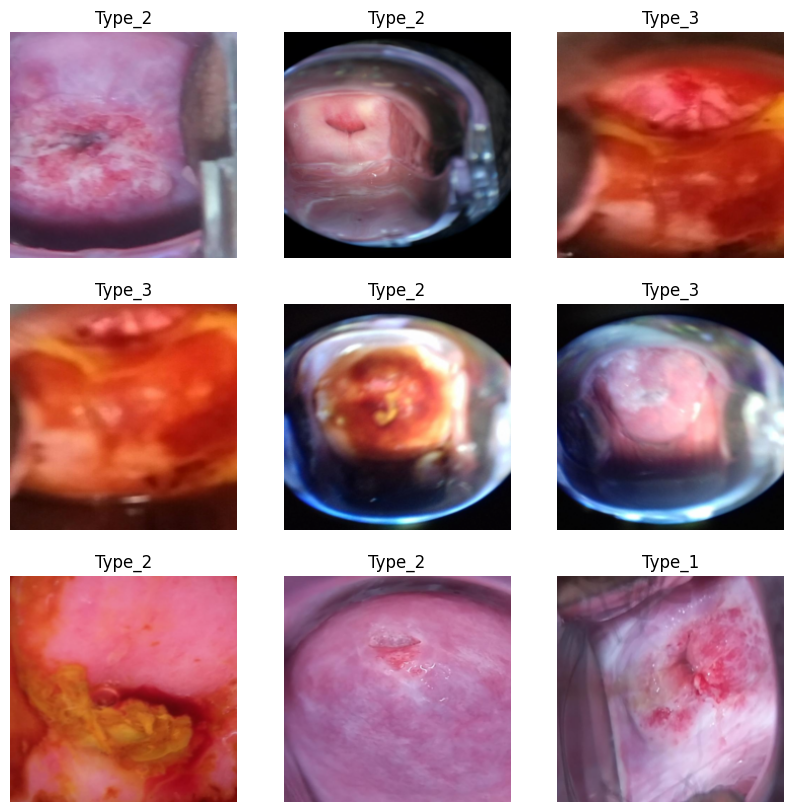

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil contoh gambar dari dataset
data_loader = dataloaders['valid']  # Ganti dengan 'valid' untuk menggunakan data dari folder validasi
class_names = image_datasets['valid'].classes  # Ganti dengan 'valid' untuk class names dari dataset validasi

# Fungsi untuk menampilkan gambar dan label
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Ambil contoh batch dari data loader
inputs, classes = next(iter(data_loader))

# Tampilkan contoh gambar
plt.figure(figsize=(10, 10))
for i in range(min(9, len(inputs))):
    ax = plt.subplot(3, 3, i + 1)
    imshow(inputs[i], title=class_names[classes[i]])
    ax.axis('off')


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class Hybrid_Resnet50_and_Mobilenetv2(nn.Module):
    def __init__(self, num_classes):
        super(Hybrid_Resnet50_and_Mobilenetv2, self).__init()
        # Buat ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, num_classes)

        # Buat MobileNetV2
        self.mobilenetv2 = models.mobilenet_v2(pretrained=True)
        num_ftrs = self.mobilenetv2.classifier[1].in_features
        self.mobilenetv2.classifier[1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        resnet_output = self.resnet50(x)
        mobilenet_output = self.mobilenetv2(x)
        # Gabungkan output dari kedua model (misalnya, dengan penggabungan sederhana)
        hybrid_output = (resnet_output + mobilenet_output) / 2
        return hybrid_output


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class Hybrid_Resnet50_and_Mobilenetv2(nn.Module):
    def __init__(self, num_classes):
        super(Hybrid_Resnet50_and_Mobilenetv2, self).__init()
        # Create ResNet50
        self.resnet50 = models.resnet50(pretrained=True)
        # Modify the classifier
        self.resnet50.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
        # Create MobileNetV2
        self.mobilenetv2 = models.mobilenet_v2(pretrained=True)
        # Modify the classifier
        self.mobilenetv2.classifier[1] = nn.Linear(self.mobilenetv2.classifier[1].in_features, num_classes)

    def forward(self, x):
        resnet_output = self.resnet50(x)
        mobilenetv2_output = self.mobilenetv2(x)
        # You can combine the two model outputs here as needed
        return resnet_output, mobilenetv2_output
